In [6]:
########################################################################################################
#Module-11: What Drives the Price of a Car?
#Provided is Kaggle Dataset vehicles.csv
#Emphasis of this Project is to Deliver...
# 1. Organized github project with all supporting files included README with Jupyter Notebook
# 2. Syntax and code quality
# 3. Visualizations : Various supporting Plots, appropriate labes and titles, legible axis
#                     Subplots are used whereever needed
# 4. Modelling: Industry standard CRISP-DM - Various Regression Models, Models and Cross Validations,
#               Evaluation Matrixs, Comparisons
# 5. Findings and Recommendations
##########################################################################################################

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [29]:
file_path = "..\\Data\\vehicles.zip"
df = pd.read_csv(file_path, compression='zip')

In [30]:
##########################################################################################################
## Process the kaggle-CSVData file and display basic info and the first few rows
## Step 1: Business Understanding
##         The goal is to understand what features impact the price of a used car. Insights should guide 
##         inventory and pricing strategy for a used car dealership.
##########################################################################################################

print("\n------- Shape: -------\n")
print(df.shape)
print("\n------- Info: --------\n")
print(df.info)
print("\n------- Head: --------\n")
print(df.head)


------- Shape: -------

(426880, 18)

------- Info: --------

<bound method DataFrame.info of                 id                  region  price    year manufacturer  \
0       7222695916                prescott   6000     NaN          NaN   
1       7218891961            fayetteville  11900     NaN          NaN   
2       7221797935            florida keys  21000     NaN          NaN   
3       7222270760  worcester / central MA   1500     NaN          NaN   
4       7210384030              greensboro   4900     NaN          NaN   
...            ...                     ...    ...     ...          ...   
426875  7301591192                 wyoming  23590  2019.0       nissan   
426876  7301591187                 wyoming  30590  2020.0        volvo   
426877  7301591147                 wyoming  34990  2020.0     cadillac   
426878  7301591140                 wyoming  28990  2018.0        lexus   
426879  7301591129                 wyoming  30590  2019.0          bmw   

                

In [31]:
##########################################################################################################
## Step 2: Understanding of the Data
## Summarize the missing values and basic statistics
##########################################################################################################

missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
# Basic statistics for numeric columns
numeric_summary = df.describe()
print("\nMissing Summary:\n")
print(missing_summary)
print("\nNumeric Summary:\n")
print(numeric_summary)
#-------------------------------------------------------------------------------------------------------------------
print("\n====ooOOOO --These high-missing-value columns may be dropped or removed selectively-- OOOOoo====\n")


Missing Summary:

              Missing Values  Percentage
size                  306361   71.767476
cylinders             177678   41.622470
condition             174104   40.785232
VIN                   161042   37.725356
drive                 130567   30.586347
paint_color           130203   30.501078
type                   92858   21.752717
manufacturer           17646    4.133714
title_status            8242    1.930753
model                   5277    1.236179
odometer                4400    1.030735
fuel                    3013    0.705819
transmission            2556    0.598763
year                    1205    0.282281
region                     0    0.000000
id                         0    0.000000
price                      0    0.000000
state                      0    0.000000

Numeric Summary:

                 id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.80433

In [11]:
##########################################################################################################
## Step 3: Prepare the Data
##         Process and Drop the Null Valued Rows
##         Get Rid of the Outliers
##         Drop unneeded Cols as well
#          Drop rows with missing critical values
##########################################################################################################

df_clean = df.dropna(subset=['price', 'year', 'odometer', 'manufacturer'])
# Remove extreme outliers
df_clean = df_clean[(df_clean['price'] > 100) & (df_clean['price'] < 100000)]
df_clean = df_clean[(df_clean['odometer'] > 0) & (df_clean['odometer'] < 500000)]
df_clean = df_clean[(df_clean['year'] >= 1980) & (df_clean['year'] <= 2023)]

# Drop unneeded columns: ID, region, VIN (personal or overly specific)
df_clean = df_clean.drop(columns=['id', 'region', 'VIN'])

print("\nDf_Clean:\n")
print(df_clean.shape)


Df_Clean:

(364359, 15)


In [12]:
##########################################################################################################
## Cont... Step 3:
## Fill remaining missing values with "unknown" or some thing which occurs frequently
##########################################################################################################

categorical_cols = df_clean.select_dtypes(include='object').columns
for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna('unknown')
# One-hot encode categorical variables
df_model = pd.get_dummies(df_clean, drop_first=True)

# Final shape check
print(df_model.shape)

(364359, 21452)


In [13]:
##########################################################################################################
## Cont... Step 3:
## Further Drop High Cardinality Cols as well
## The Kaggle-Data is still Huge and dropping some high-cardinality columns can help reduce memory usage
##########################################################################################################

high_card_cols = ['model', 'paint_color', 'state']
df_reduced = df_clean.drop(columns=high_card_cols)

# One-hot encode remaining categorical features
df_encoded = pd.get_dummies(df_reduced, drop_first=True)

# Check resulting shape
print("Dropping high-cardinality columns to reduce memory usage...\n")
print(df_encoded.shape)

Dropping high-cardinality columns to reduce memory usage...

(364359, 92)


In [14]:
##########################################################################################################
## Lets Train the Model & Start with Linear Regression
## Model-1 : Using Linear Regression
##########################################################################################################

X = df_encoded.drop('price', axis=1)
y = df_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("Linear Regression R2:", r2_score(y_test, lr_preds))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_preds)))

Linear Regression R2: 0.6488600720818146
Linear Regression RMSE: 8462.213867796387


In [15]:
##########################################################################################################
## 
## Model-2 : Using Ridge Regression
##########################################################################################################

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Ridge Regression with Grid Search
ridge = make_pipeline(StandardScaler(), Ridge())
params = {'ridge__alpha': [0.1, 1, 10]}

grid = GridSearchCV(ridge, params, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)
ridge_preds = grid.predict(X_test)
best_ridge = grid.best_estimator_

ridge_model = best_ridge.named_steps['ridge']
ridge_importance = np.abs(ridge_model.coef_)

print("Best Ridge Alpha:", grid.best_params_)
print("Ridge CV RMSE:", -grid.best_score_)

Best Ridge Alpha: {'ridge__alpha': 1}
Ridge CV RMSE: 8451.57531843429


In [16]:
##########################################################################################################
## 
## Model-3 : Using Random Forest
##########################################################################################################

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest R2:", r2_score(y_test, rf_preds))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))

Random Forest R2: 0.893905274034085
Random Forest RMSE: 4651.476027383652


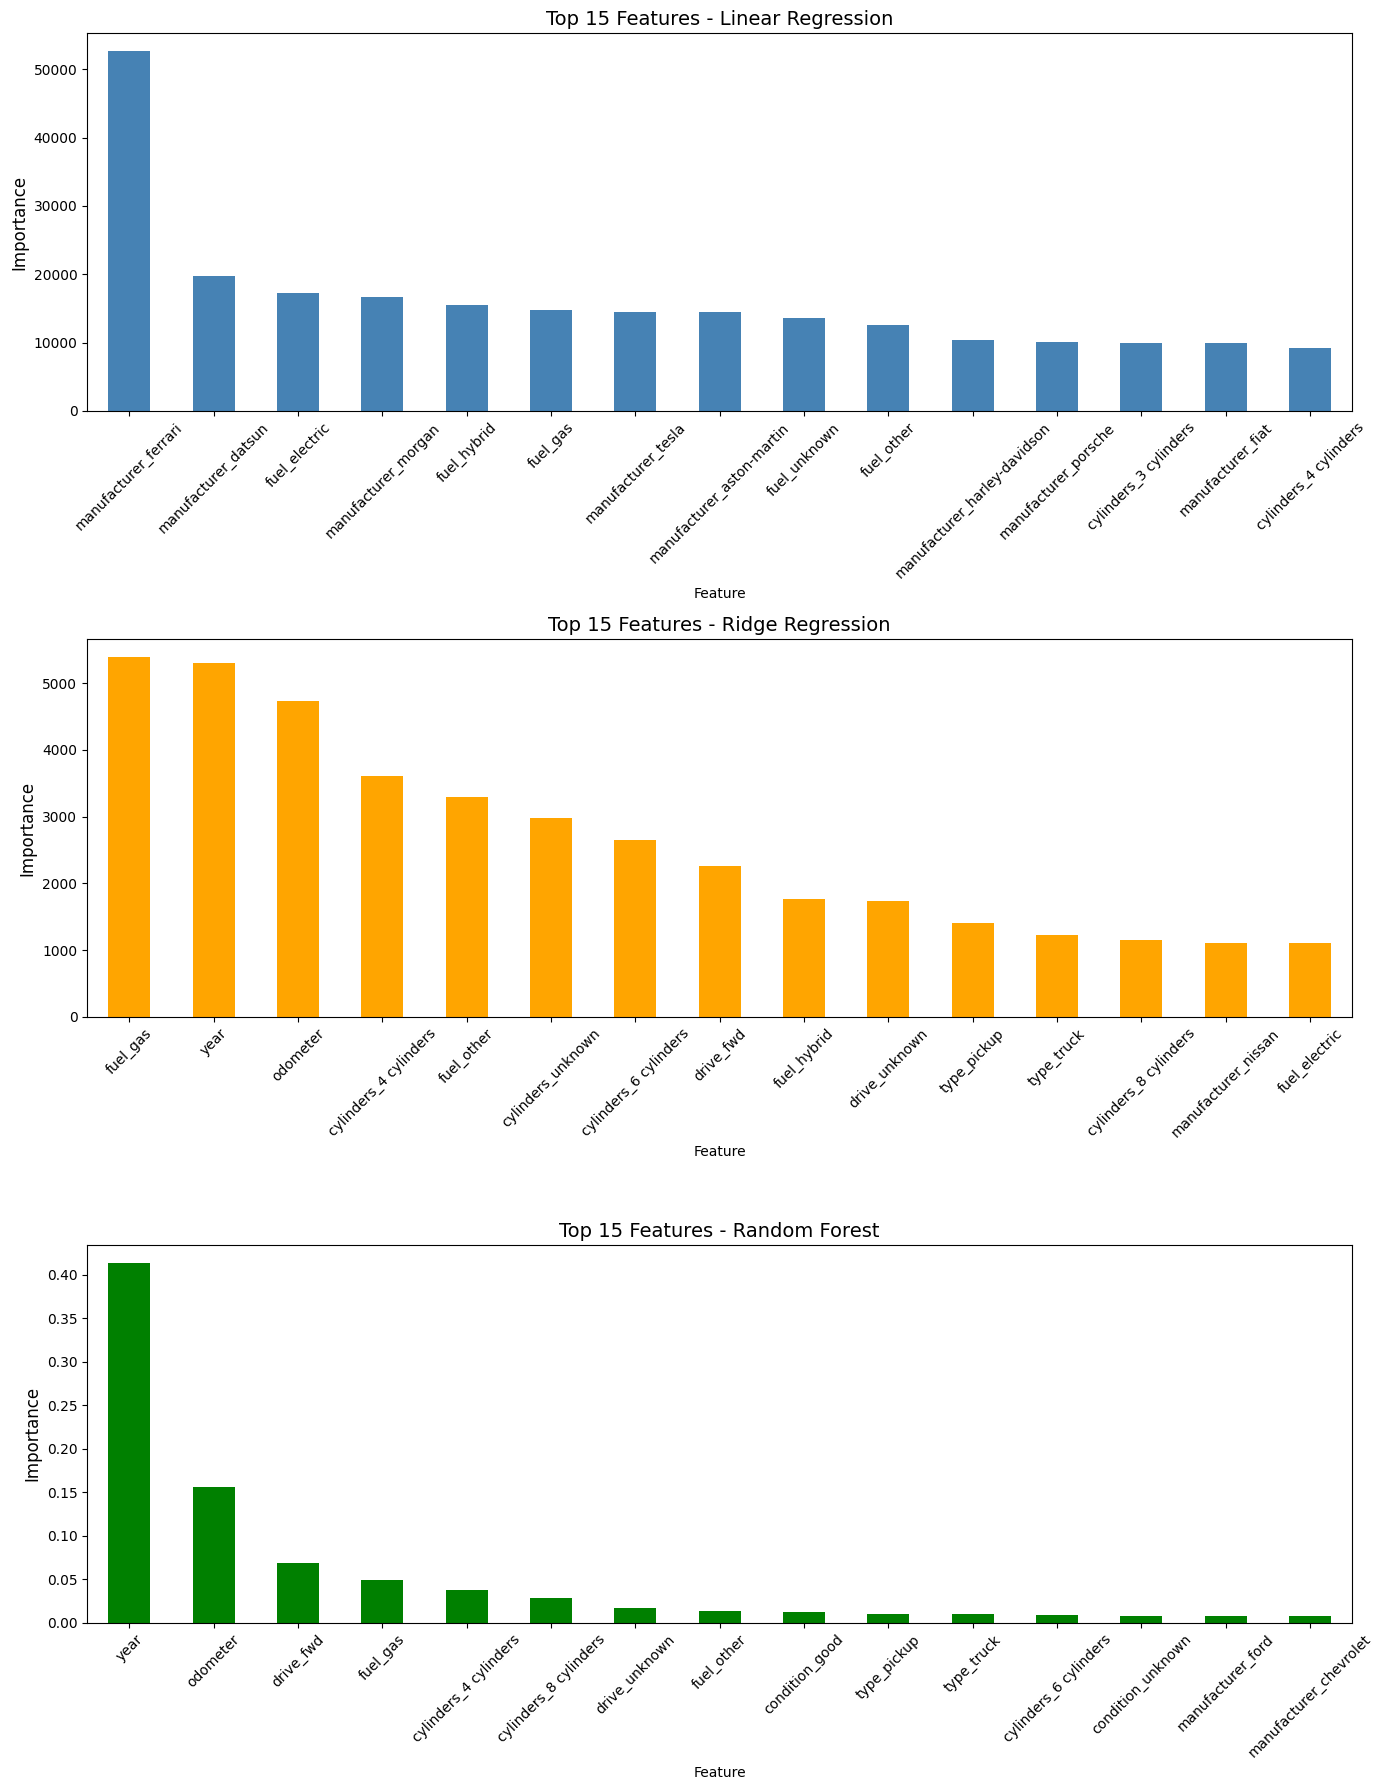

In [17]:
#######################################################################################################################
## We start by using a Pandas DataFrame that combines feature importance metrics from three different 
## models into one table for analysis and visualization.
## The Dataframe is created with...
##  > 'Feature': A list of feature names (assumed to be in the same order as the model inputs).
##  > 'Linear Regression': The absolute value of coefficients from a linear regression model (lr.coef_).
##  > 'Ridge Regression': The absolute value of coefficients from a ridge regression model (stored in ridge_importance).
##  > 'Random Forest': The feature importance scores from a fitted random forest model (rf.feature_importances_).
## The .set_index('Feature') Sets the 'Feature' column as the row index, so each row represents a feature, and 
## columns show the importances from different models.
## We build Bar Plots of Features Vs Importance for each of the Models
## PLOT-1 : BAR PLOT
########################################################################################################################

features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Linear Regression': np.abs(lr.coef_),
    'Ridge Regression': ridge_importance,
    'Random Forest': rf.feature_importances_
}).set_index('Feature')

fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Linear Regression
importance_df['Linear Regression'].sort_values(ascending=False).head(15).plot(
    kind='bar', ax=axes[0], color='steelblue')
axes[0].set_ylabel('Importance', fontsize=12)
axes[0].set_title('Top 15 Features - Linear Regression', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Ridge Regression
importance_df['Ridge Regression'].sort_values(ascending=False).head(15).plot(
    kind='bar', ax=axes[1], color='orange')
axes[1].set_ylabel('Importance', fontsize=12)
axes[1].set_title('Top 15 Features - Ridge Regression', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

# Random Forest
importance_df['Random Forest'].sort_values(ascending=False).head(15).plot(
    kind='bar', ax=axes[2], color='green')
axes[2].set_ylabel('Importance', fontsize=12)
axes[2].set_title('Top 15 Features - Random Forest', fontsize=14)
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("..\\GraphPlots\\Feature_Importance_Comparison_Bar_Subplots.png", dpi=300)
plt.show()

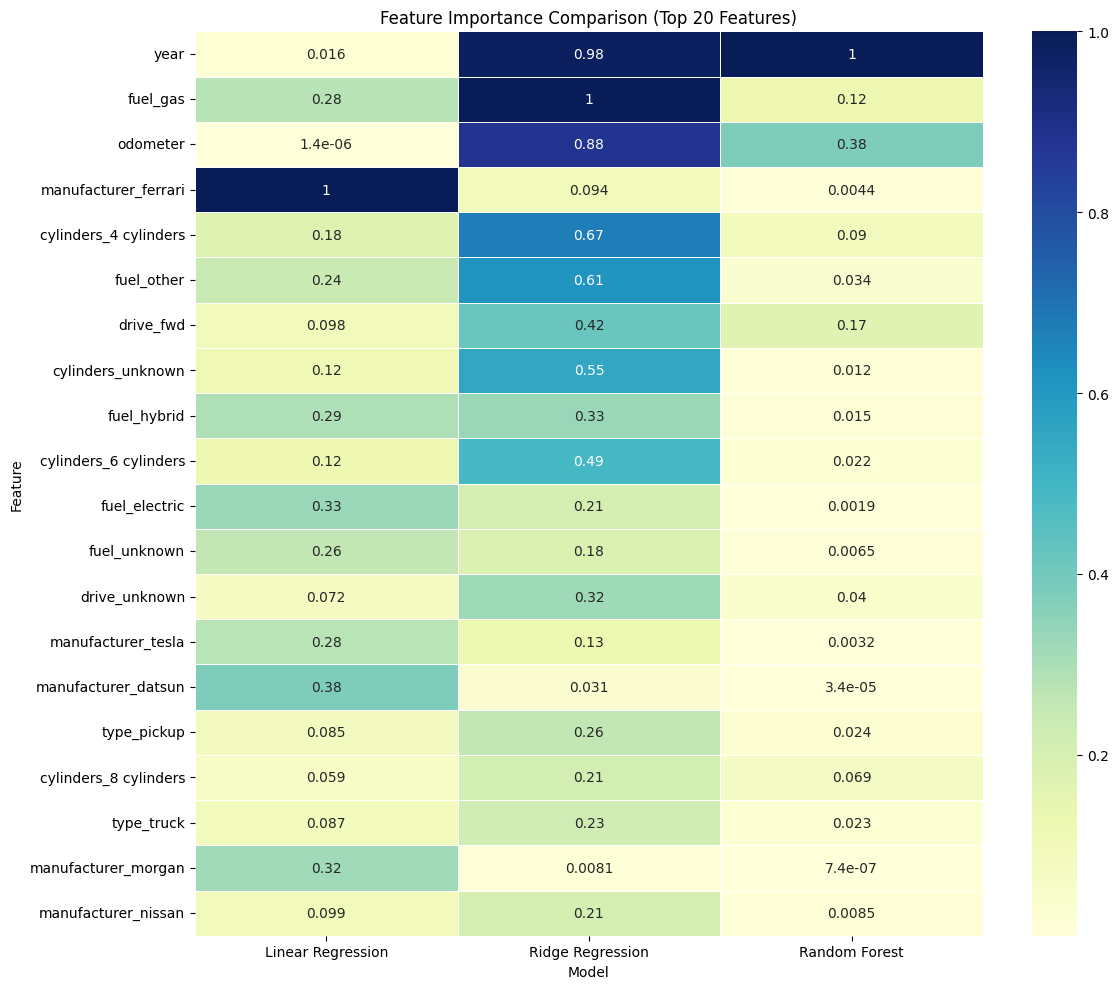

In [18]:
#######################################################################################################################
## We Plot a Heatmap comparing the Model and Feature
## PLOT-2 : HEATMAP
#######################################################################################################################

normalized_df = importance_df.copy()
normalized_df = normalized_df.div(normalized_df.max(axis=0))
#Select top 20 features by average importance across all models
top_features = normalized_df.mean(axis=1).sort_values(ascending=False).head(20).index
heatmap_data = normalized_df.loc[top_features]
#Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Feature Importance Comparison (Top 20 Features)")
plt.xlabel("Model")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("..\\GraphPlots\\Feature_Importance_Heatmap.png", dpi=300)
plt.show()

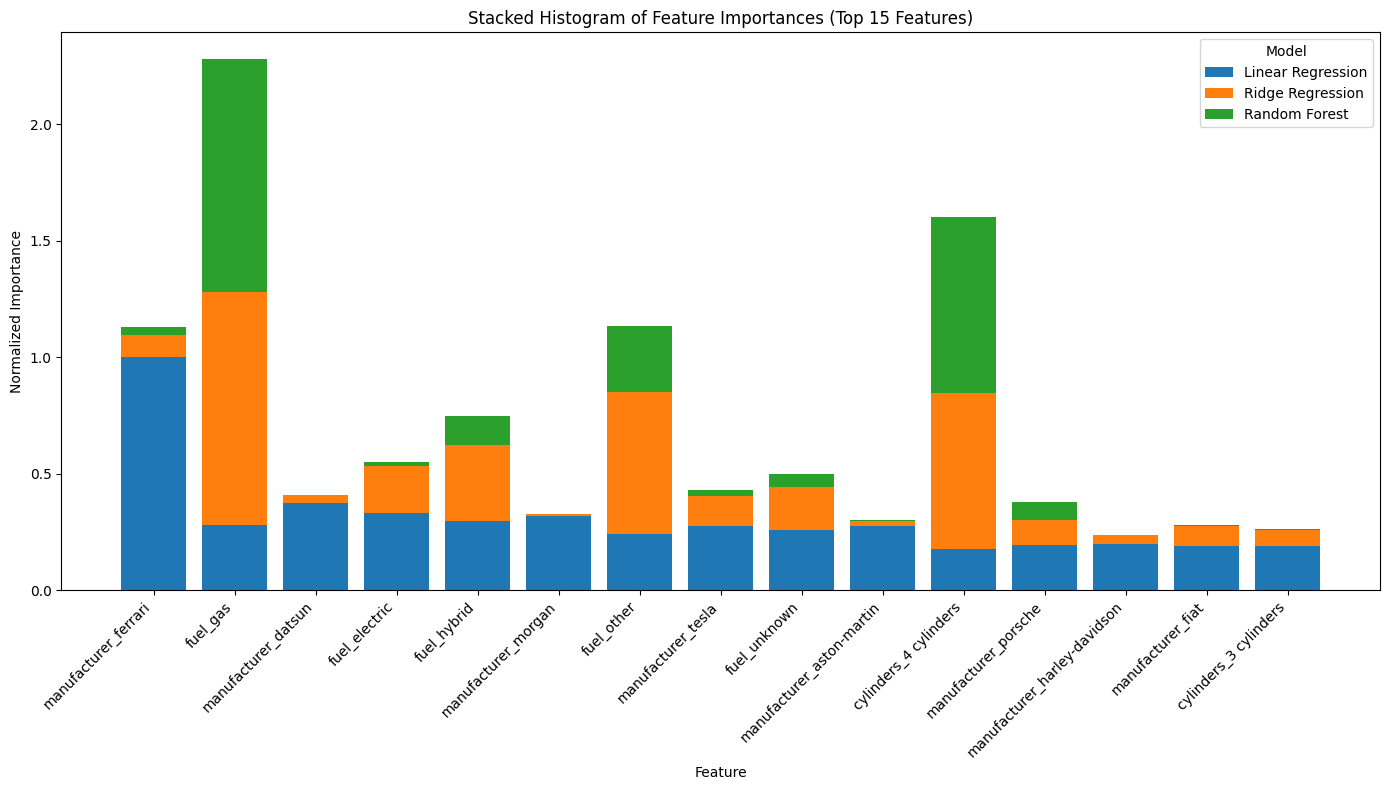

In [19]:
####################################################################################################################
## We plot a stacked Histogram comparing the Normalized Importance and Feature
## PLOT-3: Histogram (Stacked)
####################################################################################################################

top_features = importance_df.mean(axis=1).sort_values(ascending=False).head(15).index
plot_data = importance_df.loc[top_features]

# Normalize for fair visual stacking
plot_data = plot_data.div(plot_data.max(axis=0))

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each model's importance with stacking
models = plot_data.columns
bottom = np.zeros(len(plot_data))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

for i, model in enumerate(models):
    ax.bar(plot_data.index, plot_data[model], bottom=bottom, label=model, color=colors[i])
    bottom += plot_data[model]

ax.set_title('Stacked Histogram of Feature Importances (Top 15 Features)')
ax.set_ylabel('Normalized Importance')
ax.set_xlabel('Feature')
ax.set_xticks(range(len(plot_data)))
ax.set_xticklabels(plot_data.index, rotation=45, ha='right')
ax.legend(title='Model')
plt.tight_layout()
plt.savefig("..\\GraphPlots\\Feature_Importance_Histogram.png", dpi=300)
plt.show()

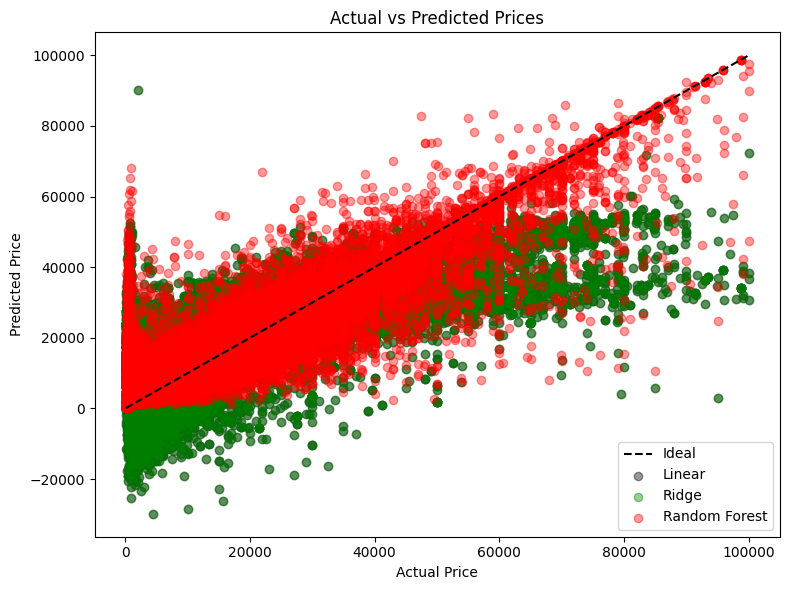

In [20]:
####################################################################################################################
## We plot a Scatter of Actual and Predicted Price
## PLOT-4: Scatter Plot
####################################################################################################################

plt.figure(figsize=(8, 6))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal')
plt.scatter(y_test, lr_preds, alpha=0.4, label='Linear', color='black')
plt.scatter(y_test, ridge_preds, alpha=0.4, label='Ridge', color='green')
plt.scatter(y_test, rf_preds, alpha=0.4, label='Random Forest', color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.tight_layout()
plt.savefig("..\\GraphPlots\\Actual_Vs_Predicted_Prices.png", dpi=300)
plt.show()

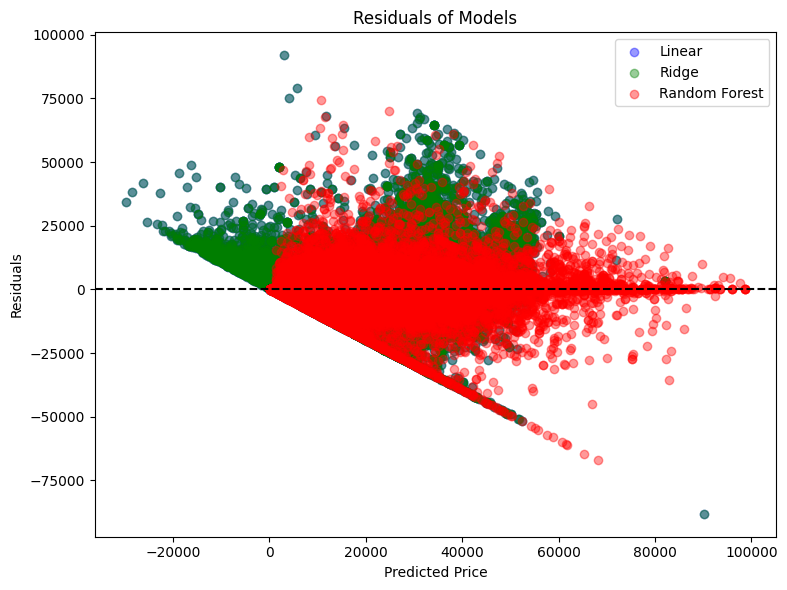

In [22]:
####################################################################################################################
## We plot a Scatter comparing the Predicted Price and Residuals(in regression are the differences between
## the actual and predicted values)
## PLOT-5: Scatter Plot
####################################################################################################################

plt.figure(figsize=(8, 6))
plt.axhline(0, linestyle='--', color='black')
plt.scatter(lr_preds, y_test - lr_preds, alpha=0.4, label='Linear', color='blue')
plt.scatter(ridge_preds, y_test - ridge_preds, alpha=0.4, label='Ridge', color='green')
plt.scatter(rf_preds, y_test - rf_preds, alpha=0.4, label='Random Forest', color='red')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.legend()
plt.title("Residuals of Models")
plt.tight_layout()
plt.savefig("..\\GraphPlots\\Predicted_Prices_Vs_Residuals.png", dpi=300)
plt.show()

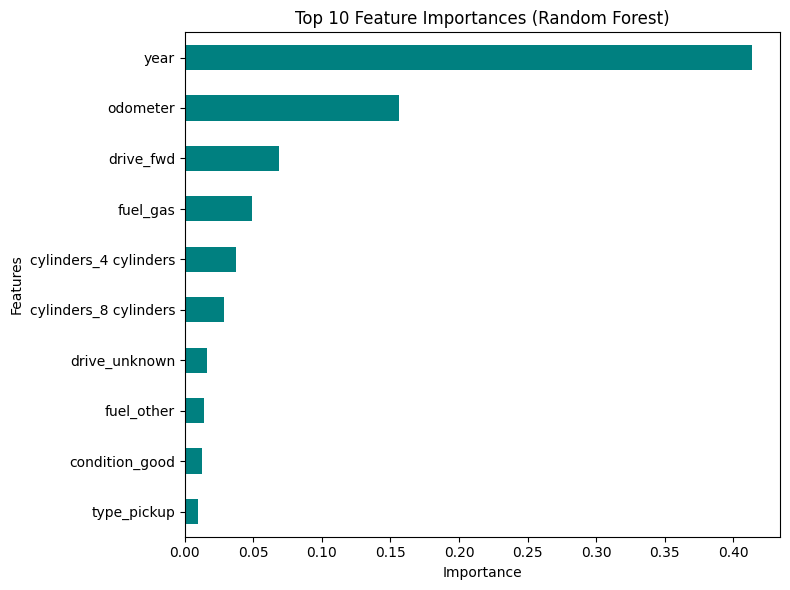

In [23]:
####################################################################################################################
## We plot a Horizontal Bar Graph comparing the Top-10-Features and Importance of it
## PLOT-6: Horizontal Bar Graph
####################################################################################################################

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
importances.plot(kind='barh', figsize=(8, 6), color='teal')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.ylabel("Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("..\\GraphPlots\\Features_Vs_Importance.png", dpi=300)
plt.show()

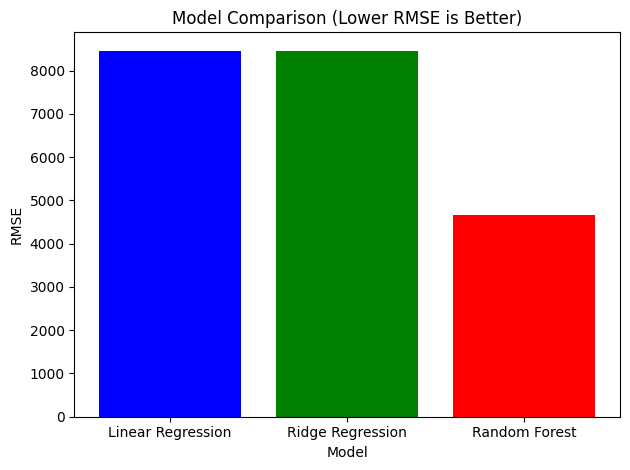

In [24]:
####################################################################################################################
## !!!!Important Graph!!!! 
## We plot a Verticle Bar Graph comparing the Analyzed Models and how the Models stand against each other
## Random Forest with the lowest RMSE : A 0 value indicates that the expected and actual values match precisely. 
## Low RMSE values show that the model makes more accurate predictions and fits the data well. Higher levels, on 
## the other hand, imply more significant mistakes and fewer accurate forecasts
## PLOT-7: Veritcle Bar Graph
####################################################################################################################


model_scores = {
    "Linear Regression": np.sqrt(mean_squared_error(y_test, lr_preds)),
    "Ridge Regression": np.sqrt(mean_squared_error(y_test, ridge_preds)),
    "Random Forest": np.sqrt(mean_squared_error(y_test, rf_preds))
}
plt.bar(model_scores.keys(), model_scores.values(), color=['blue', 'green', 'red'])
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.title("Model Comparison (Lower RMSE is Better)")
plt.tight_layout()
plt.savefig("..\\GraphPlots\\Model_Compare_Lower_RMSE.png", dpi=300)
plt.show()

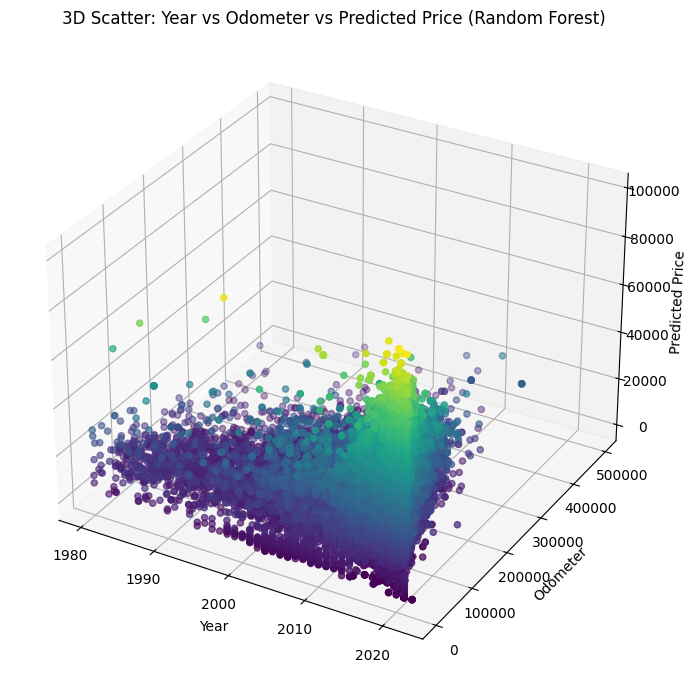

In [25]:
####################################################################################################################
## We plot a 3-D Graph Between Year, Odometer and Predicted Price
## Newer cars are priced higher. All models seem to indicate  upward trend in predicted price with increasing year
## As mileage increases, predicted price drops—clearly visible in the slope of the plot.
## Green-Random Forest may show more non-linear or scattered patterns
## PLOT-8: 3-D Graph
####################################################################################################################

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test['year'], X_test['odometer'], rf_preds, c=rf_preds, cmap='viridis')
ax.set_xlabel('Year')
ax.set_ylabel('Odometer')
ax.set_zlabel('Predicted Price')
plt.title("3D Scatter: Year vs Odometer vs Predicted Price (Random Forest)")
plt.tight_layout()
plt.savefig("..\\GraphPlots\\Year_Vs_Odometer_Vs_Predicted_Price.png", dpi=300)
plt.show()

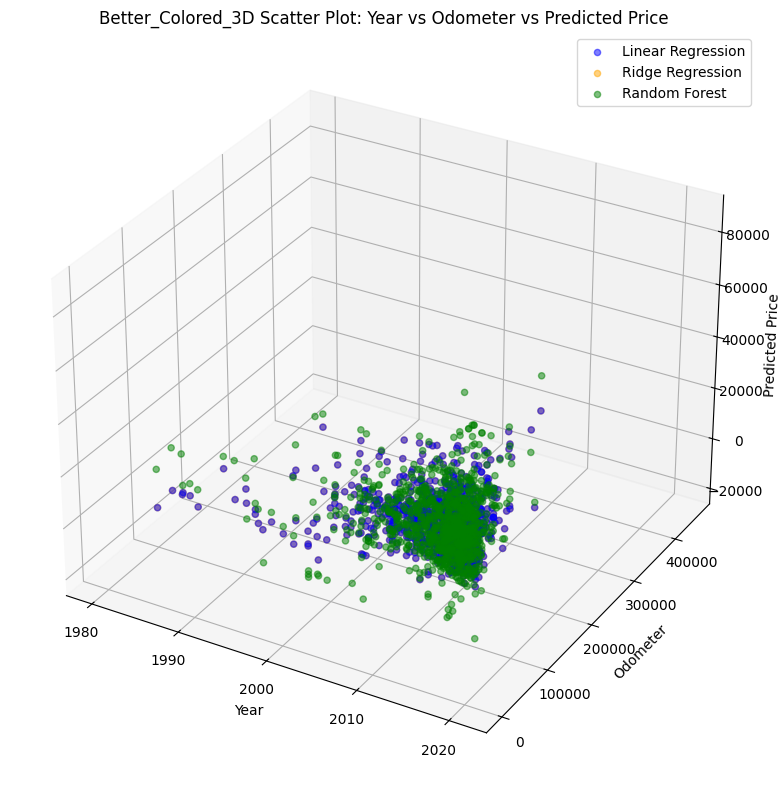

In [26]:
####################################################################################################################
## Another Colored and better 3-D Graph Between Year, Odometer and Predicted Price
## With the same read out but with lesser data points.
## Newer cars are priced higher. All models seem to indicate  upward trend in predicted price with increasing year
## As mileage increases, predicted price drops—clearly visible in the slope of the plot.
## Green-Random Forest may show more non-linear or scattered patterns
## PLOT-9: 3-D Graph
####################################################################################################################

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Sample to avoid too many points
sample_positions = np.random.choice(len(X_test), 1000, replace=False)
X_sample = X_test.iloc[sample_positions]
y_sample_lr = lr_preds[sample_positions]
y_sample_ridge = ridge_preds[sample_positions]
y_sample_rf = rf_preds[sample_positions]

# Plot each model's predictions
ax.scatter(X_sample['year'], X_sample['odometer'], y_sample_lr, color='blue', label='Linear Regression', alpha=0.5)
ax.scatter(X_sample['year'], X_sample['odometer'], y_sample_ridge, color='orange', label='Ridge Regression', alpha=0.5)
ax.scatter(X_sample['year'], X_sample['odometer'], y_sample_rf, color='green', label='Random Forest', alpha=0.5)

# Labels and legend
ax.set_xlabel('Year')
ax.set_ylabel('Odometer')
ax.set_zlabel('Predicted Price')
ax.set_title('Better_Colored_3D Scatter Plot: Year vs Odometer vs Predicted Price')
ax.legend()

plt.tight_layout()
plt.savefig("..\\GraphPlots\\Colored_Year_Vs_Odometer_Vs_Predicted_Price.png", dpi=300)
plt.show()